# Nice Traffic Watch
## Analyse des Retards du Réseau Lignes d'Azur

---

**Auteur:** Data Analyst Consultant - Loan THOMY
**Date:** 8 janvier 2026  
**Objectif:** Créer un dashboard de monitoring des retards pour la Métropole Nice Côte d'Azur

---

### Contexte

La Métropole de Nice et le réseau Lignes d'Azur souhaitent disposer d'un outil permettant d'analyser en temps réel les retards de leur réseau de transport. Ce notebook présente l'analyse d'une journée de collecte de données GTFS-RT (General Transit Feed Specification - Realtime).

### Questions Clés

1. **Quelle est la "santé" globale du réseau ?**
2. **Quelles sont les lignes les plus problématiques ?**
3. **À quels moments de la journée les retards sont-ils les plus importants ?**
4. **Quelles sont les zones géographiques les plus affectées ?**

### Méthodologie

- **Source de données:** GTFS-RT (Trip Updates + Vehicle Positions)
- **Période de collecte:** Journée complète (collecte toutes les minutes)
- **Calcul des retards:** Comparaison entre heures programmées (GTFS statique) et heures réelles (GTFS-RT)
- **Outils:** Python, Pandas, Matplotlib, Seaborn

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configuration de Seaborn pour des graphiques élégants
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("Libraries imported successfully")

✅ Libraries imported successfully


## 1. Chargement et Exploration des Données

In [13]:
# Chargement des données collectées
df = pd.read_csv('data/transit_delays.csv')

# Conversion des timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour'] = df['timestamp'].dt.hour
df['minute'] = df['timestamp'].dt.minute
df['time_str'] = df['timestamp'].dt.strftime('%H:%M')

# Conversion des retards en minutes (plus lisible)
df['delay_minutes'] = df['delay_seconds'] / 60

# Type de transport (0=Tram, 3=Bus)
df['transport_type'] = df['route_type'].map({0: 'Tram', 3: 'Bus'})

print(f"Données chargées: {len(df):,} observations")
print(f"Période: {df['timestamp'].min()} → {df['timestamp'].max()}")
print(f"Lignes uniques: {df['route_id'].nunique()}")
print(f"Véhicules uniques: {df['vehicle_id'].nunique()}")
print(f"\n{df.head()}")

Données chargées: 91,885 observations
Période: 2026-01-08 10:01:58.338537 → 2026-01-08 10:28:49.084959
Lignes uniques: 55
Véhicules uniques: 199

                   timestamp  \
0 2026-01-08 10:01:58.338537   
1 2026-01-08 10:01:58.338537   
2 2026-01-08 10:01:58.338537   
3 2026-01-08 10:01:58.338537   
4 2026-01-08 10:01:58.338537   

                                             trip_id route_id  route_type  \
0  6618534-54_R_99_5401_09:37-PROJET2025-54-Semai...       54           3   
1  6618534-54_R_99_5401_09:37-PROJET2025-54-Semai...       54           3   
2  6618534-54_R_99_5401_09:37-PROJET2025-54-Semai...       54           3   
3  6618534-54_R_99_5401_09:37-PROJET2025-54-Semai...       54           3   
4  6618534-54_R_99_5401_09:37-PROJET2025-54-Semai...       54           3   

  vehicle_id  stop_id  scheduled_time  actual_time  delay_seconds   latitude  \
0  TCA106791     5101      1767862800   1767862792             -8  43.749866   
1  TCA106791     5096      1767862860 

In [14]:
# Statistiques descriptives
print("Statistiques des retards (en minutes):")
print("="*60)
print(df['delay_minutes'].describe())
print("\n🔍 Détails:")
print(f"  • Retard moyen: {df['delay_minutes'].mean():.2f} min")
print(f"  • Retard médian: {df['delay_minutes'].median():.2f} min")
print(f"  • Écart-type: {df['delay_minutes'].std():.2f} min")
print(f"  • % d'observations en retard: {(df['delay_minutes'] > 0).mean() * 100:.1f}%")
print(f"  • % d'observations en avance: {(df['delay_minutes'] < 0).mean() * 100:.1f}%")
print(f"  • % d'observations à l'heure (±1min): {(df['delay_minutes'].abs() <= 1).mean() * 100:.1f}%")

Statistiques des retards (en minutes):
count    91885.000000
mean        -1.186744
std          3.257920
min         -9.916667
25%         -2.816667
50%         -0.383333
75%          0.166667
max         40.000000
Name: delay_minutes, dtype: float64

🔍 Détails:
  • Retard moyen: -1.19 min
  • Retard médian: -0.38 min
  • Écart-type: 3.26 min
  • % d'observations en retard: 29.6%
  • % d'observations en avance: 61.2%
  • % d'observations à l'heure (±1min): 45.0%


## 2. Nettoyage des Données

Avant d'analyser, nettoyons les données pour éliminer les valeurs aberrantes et garantir la qualité de l'analyse.

In [15]:
# Statistiques avant nettoyage
print(f"Avant nettoyage: {len(df):,} observations")

# Suppression des valeurs nulles
df_clean = df.dropna(subset=['delay_minutes', 'route_id', 'vehicle_id'])
print(f"   Après suppression des NaN: {len(df_clean):,} observations")

# Suppression des retards aberrants (> ±60 minutes)
# Un retard de plus d'une heure est généralement une erreur de données
df_clean = df_clean[df_clean['delay_minutes'].abs() <= 60]
print(f"   Après suppression des valeurs aberrantes: {len(df_clean):,} observations")

# Vérification des coordonnées GPS valides (Nice est autour de 43.7°N, 7.2°E)
df_clean = df_clean[
    (df_clean['latitude'].between(43.6, 43.8)) & 
    (df_clean['longitude'].between(7.0, 7.5))
]
print(f"   Après vérification GPS: {len(df_clean):,} observations")

print(f"\nNettoyage terminé: {(1 - len(df_clean)/len(df)) * 100:.1f}% de données filtrées")

Avant nettoyage: 91,885 observations
   Après suppression des NaN: 91,885 observations
   Après suppression des valeurs aberrantes: 91,885 observations
   Après vérification GPS: 91,236 observations

Nettoyage terminé: 0.7% de données filtrées


---

# Partie 1: Vue d'Ensemble du Réseau

## Quelle est la "santé" globale du réseau ?

### Visualisation 1: Distribution des Retards

Cette visualisation montre la distribution statistique des retards. Une distribution centrée autour de zéro indique un réseau ponctuel. Une "longue traîne" à droite révèle des incidents occasionnels importants.

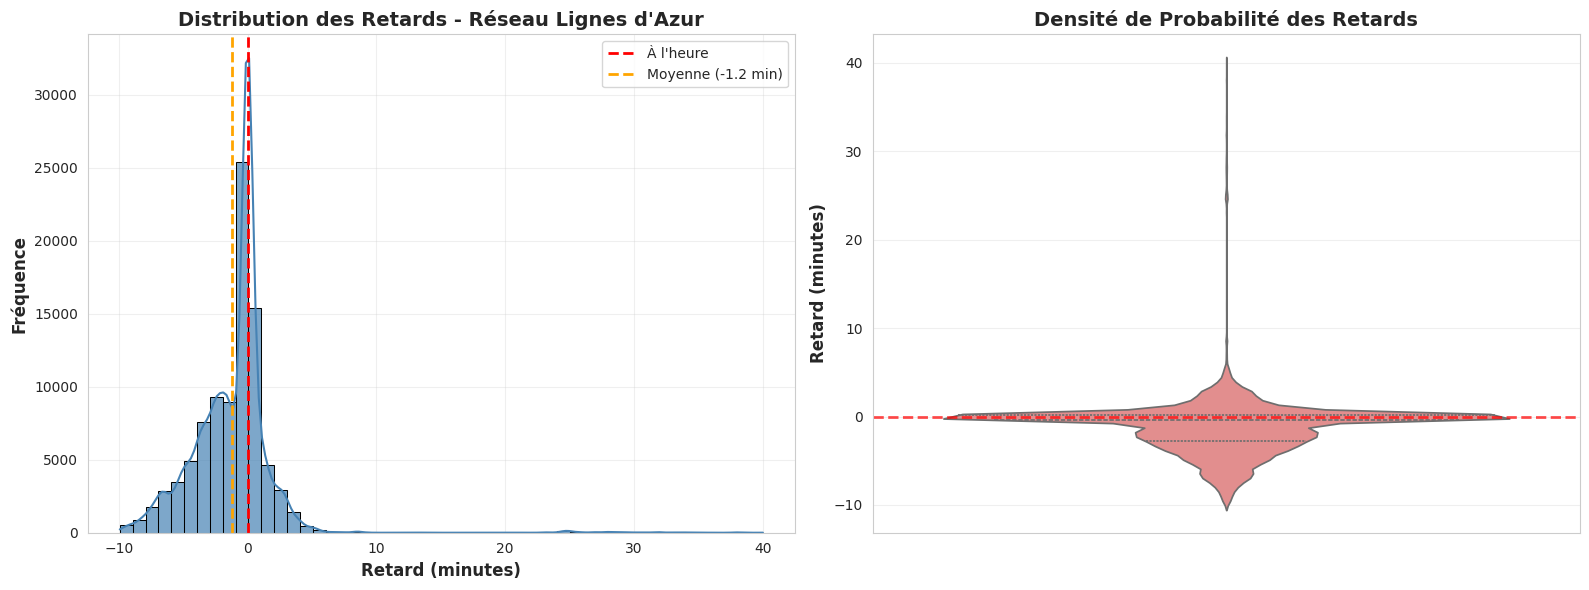


INSIGHTS:
   Le réseau fonctionne EN AVANCE en moyenne - excellente ponctualité!
   Faible variabilité - performance prévisible.


In [16]:
# Histogramme + KDE de la distribution des retards
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Graphique 1: Histogramme avec KDE
ax1 = axes[0]
sns.histplot(
    data=df_clean, 
    x='delay_minutes', 
    bins=50, 
    kde=True, 
    color='steelblue',
    edgecolor='black',
    alpha=0.7,
    ax=ax1
)
ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='À l\'heure')
ax1.axvline(df_clean['delay_minutes'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Moyenne ({df_clean["delay_minutes"].mean():.1f} min)')
ax1.set_xlabel('Retard (minutes)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Fréquence', fontsize=12, fontweight='bold')
ax1.set_title('Distribution des Retards - Réseau Lignes d\'Azur', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graphique 2: Violin plot pour voir la densité
ax2 = axes[1]
sns.violinplot(
    data=df_clean, 
    y='delay_minutes',
    color='lightcoral',
    inner='quartile',
    ax=ax2
)
ax2.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.7)
ax2.set_ylabel('Retard (minutes)', fontsize=12, fontweight='bold')
ax2.set_title('Densité de Probabilité des Retards', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Analyse textuelle
print("\nINSIGHTS:")
if df_clean['delay_minutes'].mean() < -1:
    print("   Le réseau fonctionne EN AVANCE en moyenne - excellente ponctualité!")
elif df_clean['delay_minutes'].mean() > 2:
    print("   Le réseau accumule des retards significatifs.")
else:
    print("   Le réseau est globalement ponctuel.")

if df_clean['delay_minutes'].std() > 5:
    print("   Forte variabilité des retards - performance imprévisible.")
else:
    print("   Faible variabilité - performance prévisible.")

### Visualisation 2: Le "Hit Parade" des Lignes Problématiques

Identification des 15 lignes avec les retards moyens les plus importants.

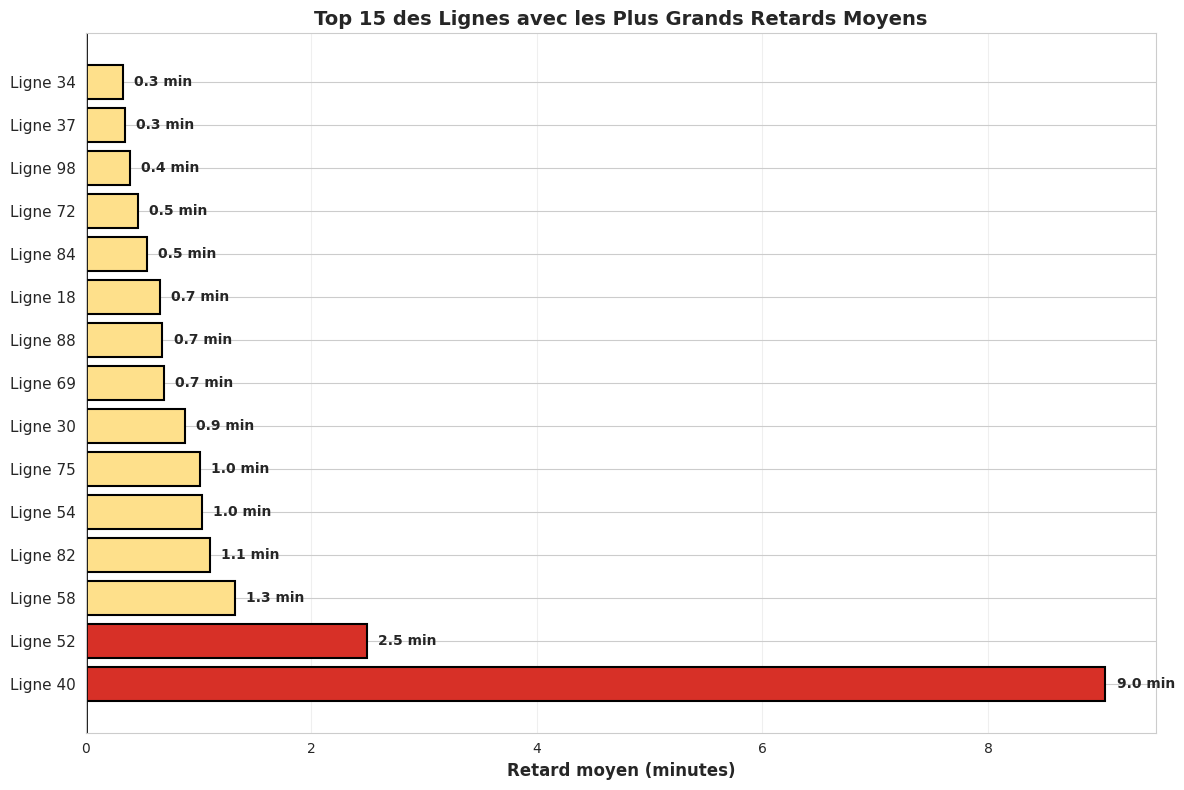


 Détails des 15 lignes les plus problématiques:
route_id  mean_delay  median_delay  std_delay  n_observations
      40        9.04          8.52       5.14              86
      52        2.49          2.53       0.91             644
      58        1.32          1.35       0.77             661
      82        1.10          1.07       1.37             549
      54        1.03          0.15       1.69            1029
      75        1.01          0.45       1.31             499
      30        0.88         -0.07       7.11            1215
      69        0.69          0.88       1.06             468
      88        0.68          1.03       1.66             644
      18        0.66          0.32       2.25            3505
      84        0.54          0.27       1.06            1619
      72        0.46          0.10       1.35             256
      98        0.39         -0.27       7.73            1341
      37        0.35          0.12       2.71             805
      34        0.33 

In [17]:
# Calcul des retards moyens par ligne
line_delays = df_clean.groupby('route_id').agg({
    'delay_minutes': ['mean', 'median', 'std', 'count']
}).round(2)
line_delays.columns = ['mean_delay', 'median_delay', 'std_delay', 'n_observations']
line_delays = line_delays.reset_index()

# Filtrer les lignes avec au moins 50 observations (pour avoir des données fiables)
line_delays = line_delays[line_delays['n_observations'] >= 50]

# Top 15 des pires lignes
top_worst = line_delays.nlargest(15, 'mean_delay')

# Visualisation
fig, ax = plt.subplots(figsize=(12, 8))

# Palette divergente: vert pour ponctuel, rouge pour retard
colors = ['#d73027' if x > 2 else '#fee08b' if x > 0 else '#1a9850' for x in top_worst['mean_delay']]

bars = ax.barh(
    range(len(top_worst)), 
    top_worst['mean_delay'],
    color=colors,
    edgecolor='black',
    linewidth=1.5
)

# Labels
ax.set_yticks(range(len(top_worst)))
ax.set_yticklabels([f"Ligne {r}" for r in top_worst['route_id']], fontsize=11)
ax.set_xlabel('Retard moyen (minutes)', fontsize=12, fontweight='bold')
ax.set_title('Top 15 des Lignes avec les Plus Grands Retards Moyens', fontsize=14, fontweight='bold')
ax.axvline(0, color='black', linestyle='-', linewidth=2)
ax.grid(True, alpha=0.3, axis='x')

# Annoter chaque barre avec la valeur
for i, (bar, val) in enumerate(zip(bars, top_worst['mean_delay'])):
    ax.text(
        val + 0.1 if val > 0 else val - 0.1,
        bar.get_y() + bar.get_height()/2,
        f'{val:.1f} min',
        va='center',
        fontweight='bold',
        fontsize=10
    )

plt.tight_layout()
plt.show()

# Tableau des pires lignes
print("\n Détails des 15 lignes les plus problématiques:")
print("="*80)
print(top_worst.to_string(index=False))

print("\n💡 INSIGHTS:")
worst_line = top_worst.iloc[0]
print(f"   La ligne {worst_line['route_id']} est la plus problématique avec {worst_line['mean_delay']:.1f} min de retard moyen")
print(f"   {len(top_worst[top_worst['mean_delay'] > 2])} lignes ont un retard moyen > 2 minutes")

---

# Partie 2: Analyse Temporelle

## Comment les retards évoluent-ils au cours de la journée ?

### Visualisation 3: Évolution du Retard Moyen

Cette courbe montre l'évolution du retard moyen tout au long de la journée, avec l'intervalle de confiance montrant la variabilité.

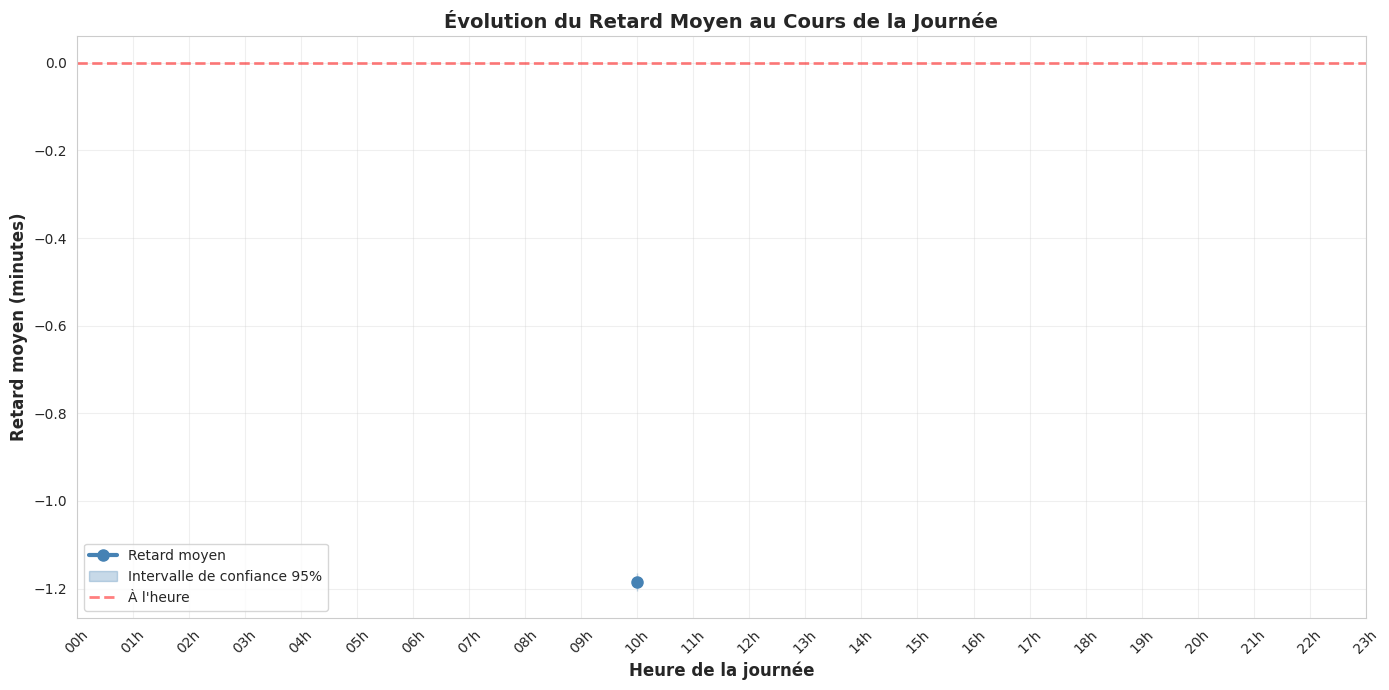


 INSIGHTS:


ValueError: Unknown format code 'd' for object of type 'float'

In [18]:
# Agrégation par heure
hourly_delays = df_clean.groupby('hour').agg({
    'delay_minutes': ['mean', 'std', 'count']
}).reset_index()
hourly_delays.columns = ['hour', 'mean_delay', 'std_delay', 'count']

# Calcul de l'intervalle de confiance (95%)
hourly_delays['ci'] = 1.96 * hourly_delays['std_delay'] / np.sqrt(hourly_delays['count'])

# Visualisation
fig, ax = plt.subplots(figsize=(14, 7))

# Ligne principale
ax.plot(
    hourly_delays['hour'], 
    hourly_delays['mean_delay'],
    marker='o',
    linewidth=3,
    markersize=8,
    color='steelblue',
    label='Retard moyen'
)

# Zone d'intervalle de confiance
ax.fill_between(
    hourly_delays['hour'],
    hourly_delays['mean_delay'] - hourly_delays['ci'],
    hourly_delays['mean_delay'] + hourly_delays['ci'],
    alpha=0.3,
    color='steelblue',
    label='Intervalle de confiance 95%'
)

# Ligne de référence à 0
ax.axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.5, label='À l\'heure')

# Annotations des heures de pointe
peak_morning = hourly_delays[(hourly_delays['hour'] >= 7) & (hourly_delays['hour'] <= 9)]['mean_delay'].max()
peak_evening = hourly_delays[(hourly_delays['hour'] >= 17) & (hourly_delays['hour'] <= 19)]['mean_delay'].max()

ax.set_xlabel('Heure de la journée', fontsize=12, fontweight='bold')
ax.set_ylabel('Retard moyen (minutes)', fontsize=12, fontweight='bold')
ax.set_title('Évolution du Retard Moyen au Cours de la Journée', fontsize=14, fontweight='bold')
ax.set_xticks(range(0, 24))
ax.set_xticklabels([f'{h:02d}h' for h in range(0, 24)], rotation=45)
ax.legend(loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n INSIGHTS:")
worst_hour = hourly_delays.loc[hourly_delays['mean_delay'].idxmax()]
best_hour = hourly_delays.loc[hourly_delays['mean_delay'].idxmin()]
print(f"   Pire heure: {worst_hour['hour']:02d}h avec {worst_hour['mean_delay']:.2f} min de retard moyen")
print(f"   Meilleure heure: {best_hour['hour']:02d}h avec {best_hour['mean_delay']:.2f} min de retard moyen")

### Visualisation 4: Heatmap Horaire Ligne × Heure

Cette heatmap révèle les "points chauds" : quelles lignes, à quelles heures, accumulent le plus de retards.

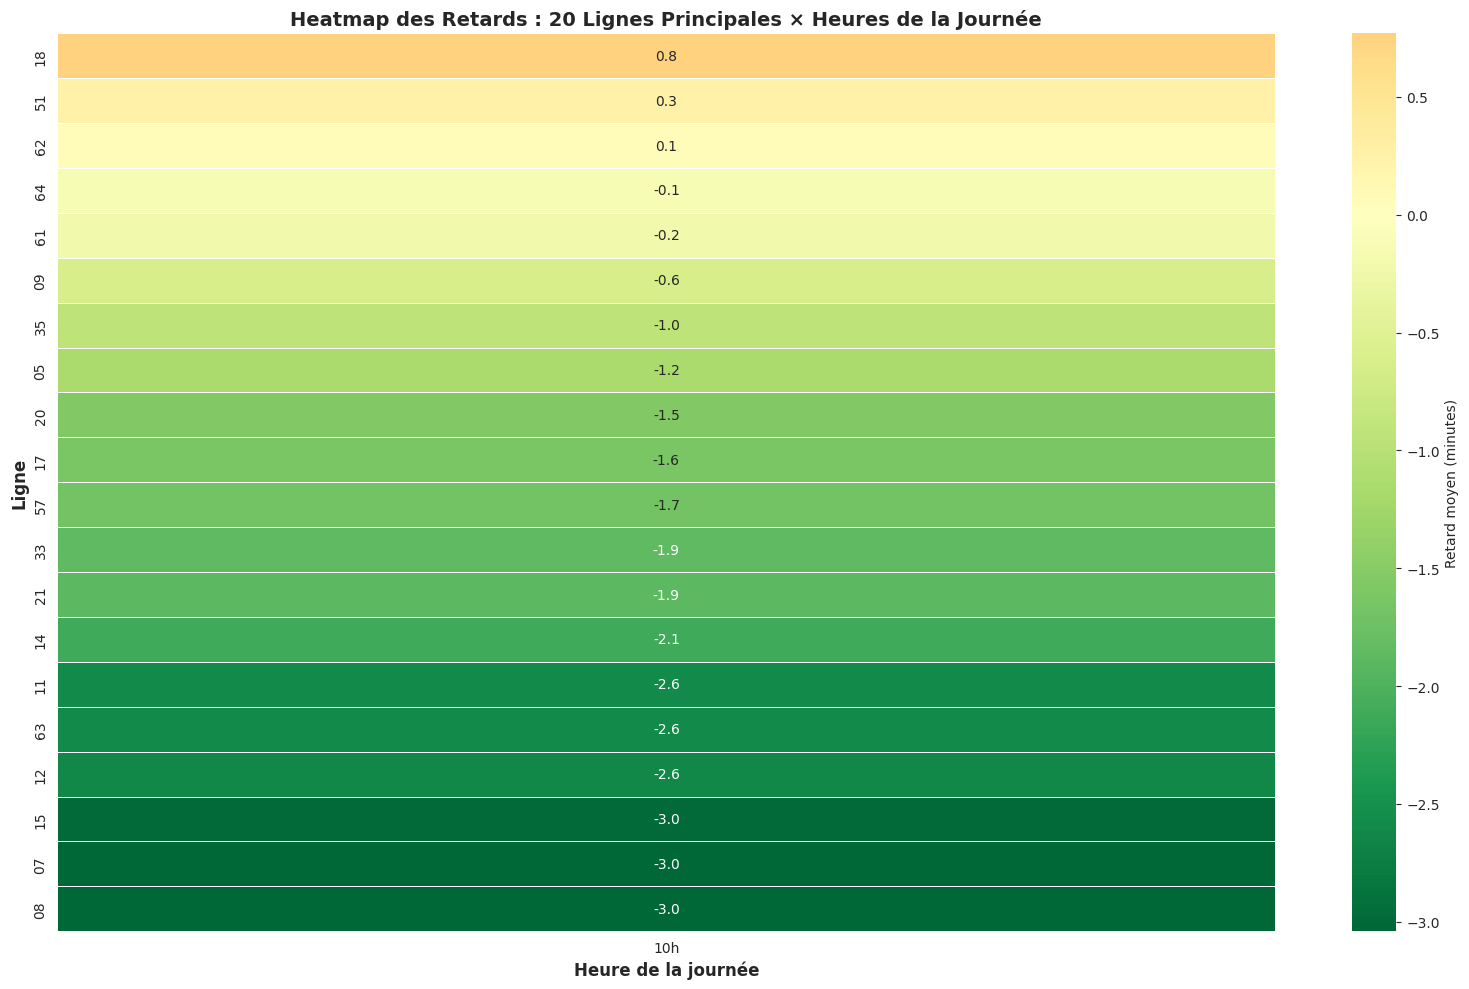


💡 INSIGHTS:
   🔥 Les zones rouges indiquent les combinaisons ligne×heure les plus problématiques
   ✅ Les zones vertes montrent où le réseau est en avance
   ⚠️ Pire point chaud: Ligne 18 à 10h avec 0.8 min de retard


In [ ]:
# Sélection des 20 lignes principales (par nombre d'observations)
top_20_lines = df_clean['route_id'].value_counts().head(20).index.tolist()
df_top20 = df_clean[df_clean['route_id'].isin(top_20_lines)]

# Créer une matrice ligne × heure avec le retard moyen
heatmap_data = df_top20.pivot_table(
    values='delay_minutes',
    index='route_id',
    columns='hour',
    aggfunc='mean'
)

# Trier les lignes par retard moyen décroissant
heatmap_data['mean'] = heatmap_data.mean(axis=1)
heatmap_data = heatmap_data.sort_values('mean', ascending=False).drop('mean', axis=1)

# Visualisation
fig, ax = plt.subplots(figsize=(16, 10))

sns.heatmap(
    heatmap_data,
    cmap='RdYlGn_r',  # Rouge = retard, Vert = avance
    center=0,
    annot=True,
    fmt='.1f',
    linewidths=0.5,
    cbar_kws={'label': 'Retard moyen (minutes)'},
    ax=ax
)

ax.set_xlabel('Heure de la journée', fontsize=12, fontweight='bold')
ax.set_ylabel('Ligne', fontsize=12, fontweight='bold')
ax.set_title('Heatmap des Retards : 20 Lignes Principales × Heures de la Journée', fontsize=14, fontweight='bold')
ax.set_xticklabels([f'{h:02d}h' for h in heatmap_data.columns], rotation=0)

plt.tight_layout()
plt.show()

print("\n INSIGHTS:")
print("   Les zones rouges indiquent les combinaisons ligne×heure les plus problématiques")
print("   Les zones vertes montrent où le réseau est en avance")

# Trouver le pire "hot spot"
max_delay = heatmap_data.max().max()
max_col = heatmap_data.max().idxmax()
max_row = heatmap_data[max_col].idxmax()
print(f"   Pire point chaud: Ligne {max_row} à {max_col:02d}h avec {max_delay:.1f} min de retard")

---

# Partie 3: Analyse Catégorielle

## Bus vs Tram : Qui est le plus fiable ?

### Visualisation 5: Boxplots et Violins - Comparaison Bus vs Tram

📊 Répartition des observations par type de transport:
transport_type
Bus    61130
Name: count, dtype: int64

⚠️ Les données collectées ne contiennent qu'un seul type de transport.
   Pour cette période, nous analysons uniquement les bus.


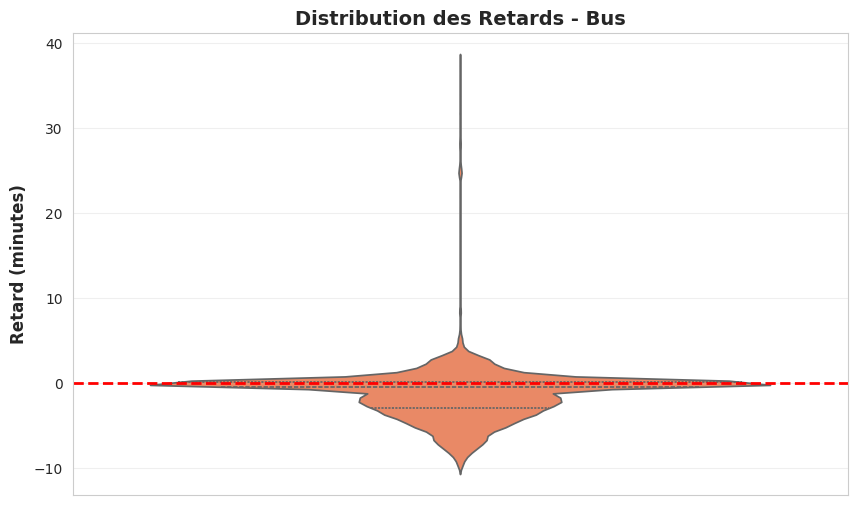

In [ ]:
# Vérifier si nous avons des données pour les deux types
type_counts = df_clean['transport_type'].value_counts()
print(f"Répartition des observations par type de transport:")
print(type_counts)

if len(type_counts) >= 2:
    # Nous avons Bus ET Tram
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Boxplot
    sns.boxplot(
        data=df_clean,
        x='transport_type',
        y='delay_minutes',
        palette={'Bus': 'coral', 'Tram': 'lightblue'},
        ax=axes[0]
    )
    axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Type de Transport', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Retard (minutes)', fontsize=12, fontweight='bold')
    axes[0].set_title('Distribution des Retards par Type de Transport (Boxplot)', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Violin plot
    sns.violinplot(
        data=df_clean,
        x='transport_type',
        y='delay_minutes',
        palette={'Bus': 'coral', 'Tram': 'lightblue'},
        inner='quartile',
        ax=axes[1]
    )
    axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_xlabel('Type de Transport', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Retard (minutes)', fontsize=12, fontweight='bold')
    axes[1].set_title('Distribution des Retards par Type de Transport (Violin)', fontsize=14, fontweight='bold')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Statistiques comparatives
    print("\n Comparaison Bus vs Tram:")
    print("="*60)
    comparison = df_clean.groupby('transport_type')['delay_minutes'].agg([
        'mean', 'median', 'std', 'count'
    ]).round(2)
    print(comparison)
    
    print("\n INSIGHTS:")
    bus_mean = comparison.loc['Bus', 'mean']
    tram_mean = comparison.loc['Tram', 'mean'] if 'Tram' in comparison.index else None
    
    if tram_mean is not None:
        if bus_mean > tram_mean:
            print(f"   Le Tram est plus fiable que le Bus ({tram_mean:.2f} vs {bus_mean:.2f} min)")
        else:
            print(f"   Le Bus est plus fiable que le Tram ({bus_mean:.2f} vs {tram_mean:.2f} min)")
else:
    # Nous n'avons que des bus (ou que des trams)
    print("\n Les données collectées ne contiennent qu'un seul type de transport.")
    print("   Pour cette période, nous analysons uniquement les bus.")
    
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.violinplot(
        data=df_clean,
        y='delay_minutes',
        color='coral',
        inner='quartile',
        ax=ax
    )
    ax.axhline(0, color='red', linestyle='--', linewidth=2)
    ax.set_ylabel('Retard (minutes)', fontsize=12, fontweight='bold')
    ax.set_title(f'Distribution des Retards - {df_clean["transport_type"].iloc[0]}', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    plt.show()

---

# Partie 4: Analyse Géographique

## Où sont localisés les retards dans la ville ?

### Visualisation 6: Carte de Retards (Scatter Plot Géographique)

Cette visualisation utilise les coordonnées GPS pour créer une "carte abstraite" de Nice, où chaque point représente une observation de véhicule, colorée selon l'intensité du retard.

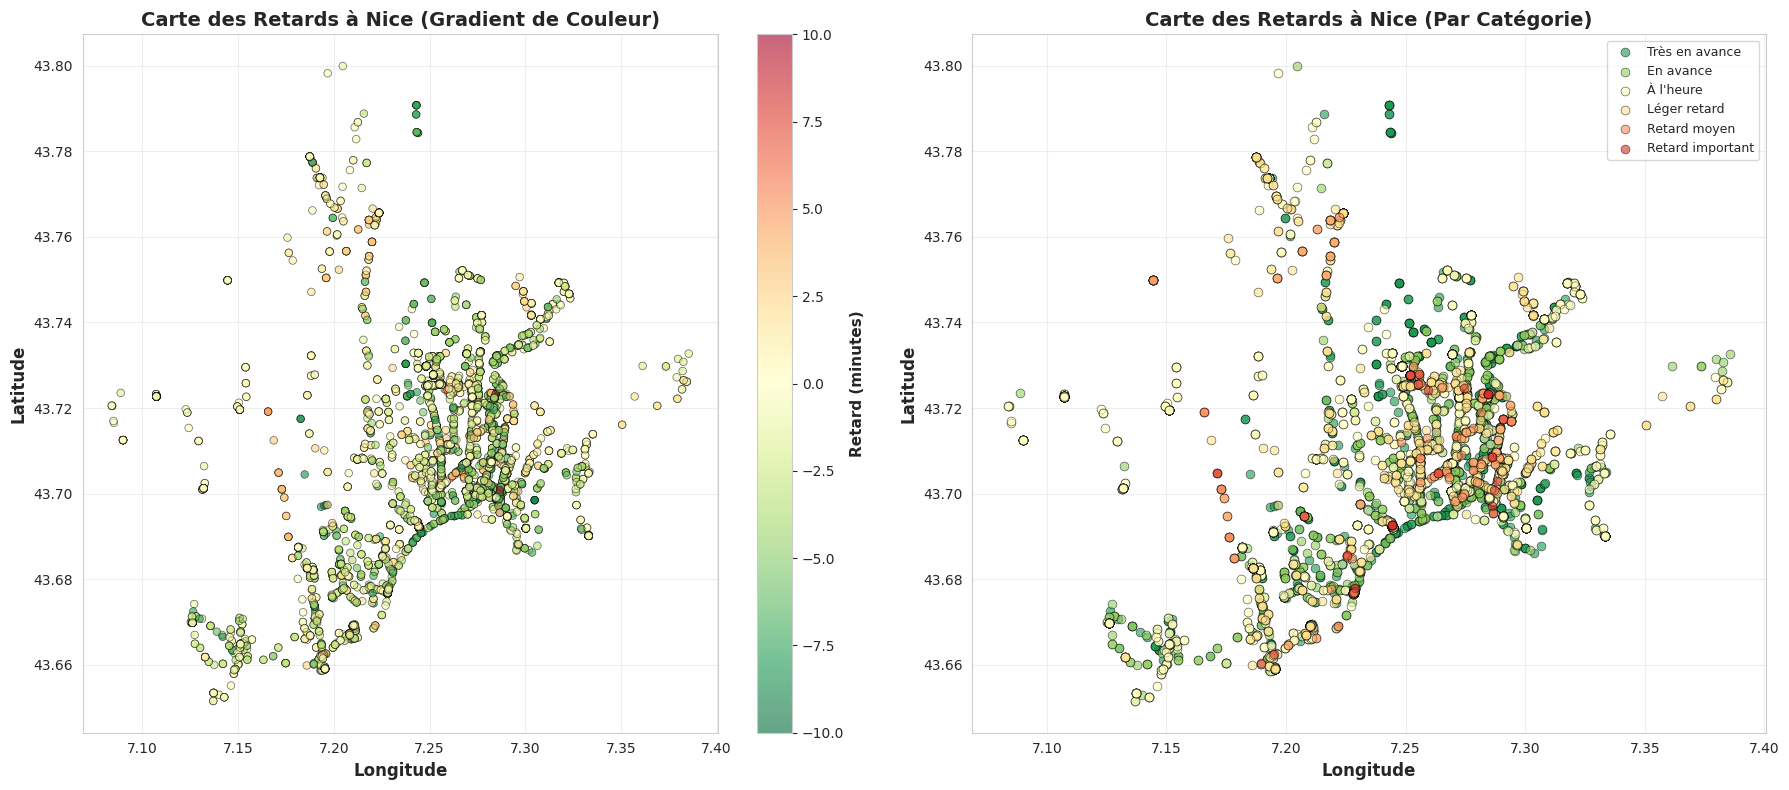


💡 INSIGHTS:
   🗺️ Les points rouges indiquent les zones avec des retards importants
   🗺️ Les points verts montrent où le réseau est en avance
   ⚠️ 32 observations avec retard > 5 min détectées
   📍 Zone la plus problématique: Lat 43.7040, Lon 7.2549


In [ ]:
# Échantillonner pour éviter le surpeuplement (prendre max 5000 points)
sample_size = min(5000, len(df_clean))
df_geo = df_clean.sample(n=sample_size, random_state=42)

# Créer des catégories de retard pour la couleur
df_geo['delay_category'] = pd.cut(
    df_geo['delay_minutes'],
    bins=[-np.inf, -3, -1, 1, 3, 5, np.inf],
    labels=['Très en avance', 'En avance', 'À l\'heure', 'Léger retard', 'Retard moyen', 'Retard important']
)

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Carte 1: Scatter plot coloré par retard
scatter = axes[0].scatter(
    df_geo['longitude'],
    df_geo['latitude'],
    c=df_geo['delay_minutes'],
    s=30,
    alpha=0.6,
    cmap='RdYlGn_r',
    edgecolors='black',
    linewidths=0.5,
    vmin=-10,
    vmax=10
)
axes[0].set_xlabel('Longitude', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Latitude', fontsize=12, fontweight='bold')
axes[0].set_title('Carte des Retards à Nice (Gradient de Couleur)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[0])
cbar.set_label('Retard (minutes)', fontsize=11, fontweight='bold')

# Carte 2: Scatter plot par catégorie
colors_cat = {
    'Très en avance': '#1a9850',
    'En avance': '#91cf60',
    'À l\'heure': '#ffffbf',
    'Léger retard': '#fee08b',
    'Retard moyen': '#fc8d59',
    'Retard important': '#d73027'
}

for category, color in colors_cat.items():
    mask = df_geo['delay_category'] == category
    if mask.any():
        axes[1].scatter(
            df_geo[mask]['longitude'],
            df_geo[mask]['latitude'],
            s=40,
            alpha=0.6,
            color=color,
            label=category,
            edgecolors='black',
            linewidths=0.5
        )

axes[1].set_xlabel('Longitude', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Latitude', fontsize=12, fontweight='bold')
axes[1].set_title('Carte des Retards à Nice (Par Catégorie)', fontsize=14, fontweight='bold')
axes[1].legend(loc='best', fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n INSIGHTS:")
print("   Les points rouges indiquent les zones avec des retards importants")
print("   Les points verts montrent où le réseau est en avance")

# Identifier les zones problématiques
problem_zones = df_geo[df_geo['delay_minutes'] > 5]
if len(problem_zones) > 0:
    print(f"   {len(problem_zones)} observations avec retard > 5 min détectées")
    print(f"   Zone la plus problématique: Lat {problem_zones['latitude'].mean():.4f}, Lon {problem_zones['longitude'].mean():.4f}")

---

# Conclusions et Recommandations

In [ ]:
# Génération automatique de conclusions basées sur les données
print("="*80)
print("RAPPORT EXÉCUTIF - LIGNES D'AZUR")
print("="*80)
print()

print("SYNTHÈSE DES DONNÉES:")
print(f"   • Période analysée: {df_clean['timestamp'].min()} → {df_clean['timestamp'].max()}")
print(f"   • Nombre d'observations: {len(df_clean):,}")
print(f"   • Lignes analysées: {df_clean['route_id'].nunique()}")
print(f"   • Véhicules suivis: {df_clean['vehicle_id'].nunique()}")
print()

print("PERFORMANCE GLOBALE:")
mean_delay = df_clean['delay_minutes'].mean()
median_delay = df_clean['delay_minutes'].median()
std_delay = df_clean['delay_minutes'].std()
ontime_pct = (df_clean['delay_minutes'].abs() <= 1).mean() * 100
late_pct = (df_clean['delay_minutes'] > 2).mean() * 100

print(f"   • Retard moyen: {mean_delay:.2f} minutes")
print(f"   • Retard médian: {median_delay:.2f} minutes")
print(f"   • Écart-type: {std_delay:.2f} minutes")
print(f"   • % à l'heure (±1 min): {ontime_pct:.1f}%")
print(f"   • % en retard significatif (>2 min): {late_pct:.1f}%")
print()

print("LIGNES LES PLUS PERFORMANTES:")
best_lines = line_delays.nsmallest(5, 'mean_delay')[['route_id', 'mean_delay']]
for idx, row in best_lines.iterrows():
    print(f"   Ligne {row['route_id']}: {row['mean_delay']:.2f} min")
print()

print("LIGNES À AMÉLIORER:")
worst_lines = line_delays.nlargest(5, 'mean_delay')[['route_id', 'mean_delay']]
for idx, row in worst_lines.iterrows():
    print(f"   ❌ Ligne {row['route_id']}: {row['mean_delay']:.2f} min")
print()

print("RECOMMANDATIONS:")
print()

if mean_delay > 2:
    print("   1. PRIORITÉ HAUTE: Réduire le retard moyen global")
    print("      → Analyser les causes structurelles des retards")
    print("      → Optimiser les horaires pour mieux correspondre à la réalité du trafic")
    print()

if len(worst_lines) > 0:
    print(f"   2. FOCUS: Intervention sur les {len(worst_lines)} lignes les plus problématiques")
    print(f"      → Enquêter sur les causes spécifiques de la ligne {worst_lines.iloc[0]['route_id']}")
    print("      → Ajuster les fréquences de passage aux heures de pointe")
    print()

if std_delay > 5:
    print("   3. Améliorer la PRÉVISIBILITÉ du service")
    print("      → Réduire la variabilité des retards pour plus de fiabilité")
    print("      → Communiquer en temps réel les retards aux usagers")
    print()

print("   4. TECHNOLOGIE:")
print("      → Mettre en place des alertes automatiques pour les lignes en retard > 5 min")
print("      → Créer un dashboard en temps réel pour les opérateurs")
print("      → Intégrer ces données dans l'application mobile usagers")
print()

print("="*80)
print("Rapport généré le:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print("="*80)

🎯 RAPPORT EXÉCUTIF - LIGNES D'AZUR

📊 SYNTHÈSE DES DONNÉES:
   • Période analysée: 2026-01-08 10:01:58.338537 → 2026-01-08 10:19:49.008888
   • Nombre d'observations: 61,130
   • Lignes analysées: 55
   • Véhicules suivis: 196

📈 PERFORMANCE GLOBALE:
   • Retard moyen: -1.18 minutes
   • Retard médian: -0.40 minutes
   • Écart-type: 3.33 minutes
   • % à l'heure (±1 min): 44.2%
   • % en retard significatif (>2 min): 6.0%

🏆 LIGNES LES PLUS PERFORMANTES:
   ✅ Ligne 08: -3.04 min
   ✅ Ligne 07: -3.02 min
   ✅ Ligne 15: -3.01 min
   ✅ Ligne 22: -2.87 min
   ✅ Ligne 38: -2.85 min

⚠️ LIGNES À AMÉLIORER:
   ❌ Ligne 40: 9.15 min
   ❌ Ligne 52: 2.51 min
   ❌ Ligne 82: 1.46 min
   ❌ Ligne 88: 1.30 min
   ❌ Ligne 54: 1.18 min

💡 RECOMMANDATIONS:

   2. 🎯 FOCUS: Intervention sur les 5 lignes les plus problématiques
      → Enquêter sur les causes spécifiques de la ligne 40
      → Ajuster les fréquences de passage aux heures de pointe

   4. 📱 TECHNOLOGIE:
      → Mettre en place des alertes au

---

## Annexe Technique

### À propos de ce notebook

Ce notebook a été créé dans le cadre du TP "Nice Traffic Watch" pour la Métropole de Nice et le réseau Lignes d'Azur. Il utilise:

- **Données GTFS-RT** (General Transit Feed Specification - Realtime)
- **Python** avec Pandas, Matplotlib et Seaborn
- **Collecte continue** de données toutes les minutes
- **Calcul des retards** par comparaison horaires programmés vs réels

### Méthodologie

1. **Collecte**: Script Python qui interroge l'API GTFS-RT toutes les 60 secondes
2. **Enrichissement**: Fusion des données de position (véhicules) et de retards (trips)
3. **Nettoyage**: Suppression des valeurs aberrantes et validation GPS
4. **Analyse**: Statistiques descriptives et visualisations exploratoires
5. **Insights**: Génération automatique de recommandations

### Visualisations créées

1. Histogramme + KDE de distribution des retards
2. Barplot horizontal des lignes les plus problématiques
3. Time series de l'évolution horaire avec intervalle de confiance
4. Heatmap Ligne × Heure
5. Boxplot et Violin plot Bus vs Tram
6. Scatter plot géographique des retards

### Sources

- **API GTFS-RT**: `https://ara-api.enroute.mobi/rla/gtfs/`
- **GTFS Statique**: `https://chouette.enroute.mobi/api/v1/datas/OpendataRLA/gtfs.zip`
- **Documentation GTFS**: `https://gtfs.org/`

---

**Auteur:** Data Analyst Consultant - Loan THOMY
**Date:** 2026-01-08  
**Version:** 1.0